# MÔ HÌNH HÓA DỮ LIỆU
- **VỀ DỮ LIỆU:** Dữ liệu được thu thập thêm từ thông tin chi tiết của các địa điểm của một quốc gia. Có các cột là giá trị các thông tin chi tiết đó. Và có một cột target chính là kết quả mà ta sẽ suy ra từ bộ dữ liệu input. Dữ liệu có thể được cập nhật theo ngày tháng, do đó dữ liệu sẽ gần như vô hạn. Tuy nhiên, ta chỉ dùng một ngày cố định, thường sẽ dùng today().
- VỀ MÔ HÌNH: Ta sẽ chọn 2 mô hình:
  - Mô hình gom nhóm KMeans.
  - Mô hình hồi quy tuyến tính Linear Regression.

In [195]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
 
# models
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn import datasets
from scipy.spatial.distance import cdist

Đọc file input dữ liệu, ta chỉ lấy dữ liệu gần nhất, dữ liệu today()

In [196]:
from os import walk
filenames = next(walk('./data/data'), (None, None, []))[2]  # [] if no file
filename = filenames[-1]
df = pd.read_csv(f'./data/data/{filename}')
df.head()

,Thời tiết,Nhiệt độ,Độ ẩm,Gió,Áp suất,PM2.5,PM10,O3,NO2,SO2,CO,target
0,Trời quang,11°C,52%,8.8 km/h,1017 mbar,61.3,185.3,2,52.2,10.4,1160.0,Không lành mạnh
1,Trời quang,12°C,44%,9.4 km/h,1016 mbar,139.2,245.5,4.5,44.6,8.8,1150.0,Không lành mạnh
2,Nhiều mây,-4°C,45%,5 km/h,1036 mbar,157,416.5,9,59,27.5,NaN,Rất không lành mạnh
3,Sương mù,12°C,87%,7.4 km/h,1016 mbar,123.9,222.3,23,54.8,NaN,NaN,Không lành mạnh
4,Trời quang,12°C,56%,7.1 km/h,1016 mbar,83.3*,NaN,NaN,NaN,NaN,NaN,Không lành mạnh


Quy các kiểu dữ liệu `string` về thành `int` để có thể tính mean

In [197]:
weather = ['Nhiều mây', 'Trời quang', 'Mưa', 'Mây rải rác', 'Sương mù', 'Ít mây', 'Tuyết', 'Mưa rào', 'Giông bão']
target = ['Tốt', 'Trung bình', 'Không lành mạnh', 'Không lành mạnh cho các nhóm nhạy cảm', 
          'Rất không lành mạnh', 'Nguy hiểm']
df = df.replace(weather, np.arange(len(weather)))
df = df.replace(target, np.arange(len(target)))
df.head()

,Thời tiết,Nhiệt độ,Độ ẩm,Gió,Áp suất,PM2.5,PM10,O3,NO2,SO2,CO,target
0,1,11°C,52%,8.8 km/h,1017 mbar,61.3,185.3,2,52.2,10.4,1160.0,2
1,1,12°C,44%,9.4 km/h,1016 mbar,139.2,245.5,4.5,44.6,8.8,1150.0,2
2,0,-4°C,45%,5 km/h,1036 mbar,157,416.5,9,59,27.5,NaN,4
3,4,12°C,87%,7.4 km/h,1016 mbar,123.9,222.3,23,54.8,NaN,NaN,2
4,1,12°C,56%,7.1 km/h,1016 mbar,83.3*,NaN,NaN,NaN,NaN,NaN,2


Format lại các thông tin trong dữ liệu

In [198]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    df['Nhiệt độ'] = df['Nhiệt độ'].str.replace('°C', '')
    df['Độ ẩm'] = df['Độ ẩm'].str.replace('%', '')
    df['Gió'] = df['Gió'].str.replace(' km/h', '')
    df['Áp suất'] = df['Áp suất'].str.replace(' mbar', '')
    df[' PM2.5 '] = df[' PM2.5 '].str.replace('*', '')
    df[' PM10 '] = df[' PM10 '].str.replace('*', '')
    df[' O3 '] = df[' O3 '].str.replace('*', '')
    df[' NO2 '] = df[' NO2 '].str.replace('*', '')
    df[' SO2 '] = df[' SO2 '].str.replace('*', '')

In [199]:
df = df.astype(np.float64)
df.head()

,Thời tiết,Nhiệt độ,Độ ẩm,Gió,Áp suất,PM2.5,PM10,O3,NO2,SO2,CO,target
0,1.0,11.0,52.0,8.8,1017.0,61.3,185.3,2.0,52.2,10.4,1160.0,2.0
1,1.0,12.0,44.0,9.4,1016.0,139.2,245.5,4.5,44.6,8.8,1150.0,2.0
2,0.0,-4.0,45.0,5.0,1036.0,157.0,416.5,9.0,59.0,27.5,NaN,4.0
3,4.0,12.0,87.0,7.4,1016.0,123.9,222.3,23.0,54.8,NaN,NaN,2.0
4,1.0,12.0,56.0,7.1,1016.0,83.3,NaN,NaN,NaN,NaN,NaN,2.0


## MÔ HÌNH 1: **KMEANS**
- X sẽ là các cột dữ liệu thông tin về thời tiết và không khí.
- Y sẽ là các kết quả thực tế đo được.

Như đã thấy thì dữ liệu của mô hình có các giá trị NaN. Ta không thể drop các giá trị đó hoặc thay bằng 0, có nhiều cách để thay thế giá trị NaN, tuy nhiên ở đây chúng ta sẽ thay các giá trị NaN bằng mean.

In [200]:
X = df.iloc[:, :-1]
Y = df['target']

imputer = SimpleImputer(missing_values = np.nan, strategy = 'mean')
imputer = imputer.fit(X)
X = imputer.transform(X)

### Dùng **Kmeans** để gom nhóm các giá trị input và dự đoán xem sẽ có bao nhiêu nhóm dựa vào **Elbow method**.

In [201]:
y_kmeans = []
ineria = []

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for i in range(2, 10):
        kmeans = KMeans(n_clusters = i, random_state = 0).fit(X)
        y_kmeans.append(kmeans.labels_)
        ineria.append(kmeans.inertia_)

Việc kiểm tra bằng mắt đôi khi không khả thi (giả sử khi số lượng mẫu thử và sai quá lớn). Do đó, cần một độ đo để kiểm tra chất lượng gom cụm. Tiếp theo, các bạn sẽ tìm hiểu và trình bày ngắn gọn về **Elbow method**. Sau đó, bạn sẽ trực quan hóa kết quả sử dụng **Elbow method** để chọn được số cụm thích hợp.

Tìm hiểu và trình bày về **Elbow method**
- Trong phương pháp gom nhóm, thì Elbow method là một heuristic được xác định số lượng cụm trong một tập dữ liệu.
- Phương pháp bao gồm vẽ đồ thị biến thể được giải thích dưới dạng một hàm của số lượng cụm và chọn các khớp của đường cong là số lượng trục.
- Điểm khuỷ tay là điểm mà ở đó tốc độ suy giảm của hàm biến dạng sẽ thay đổi nhiều nhất. Tức là kể từ sau vị trí này thì gia tăng thêm số lượng cụm cũng không giúp hàm biến dạng giảm đáng kể. Nếu thuật toán phân chia theo số lượng cụm tại vị trí này sẽ đạt được tính chất phân cụm một cách tổng quát nhất mà không gặp các hiện tượng vị khớp (overfitting)

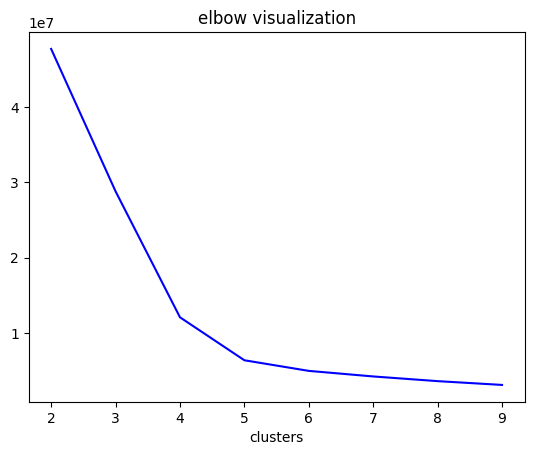

In [202]:
plt.plot(np.arange(2, 10), ineria, 'b-')
plt.xlabel('clusters')
plt.title('elbow visualization')
plt.show()

**Kết luận:** Số cụm phù hợp là 4, 5